In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

os.chdir('/content/drive/My Drive/GitHub Repositories/Transfer Learning and Fine Tuning with Pre-Trained Networks')
trainDir = './datasets/melanoma/train'
validDir = './datasets/melanoma/valid'
testDir = './datasets/melanoma/test'

IMG_SIZE = 224

datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

train_gen = datagen.flow_from_directory(directory=trainDir,
                                        target_size=(IMG_SIZE, IMG_SIZE),
                                        color_mode="rgb",
                                        batch_size=32,
                                        class_mode='categorical',
                                        shuffle=True,
                                        seed=2020)

val_datagen = ImageDataGenerator(rescale=1./255)

valid_gen = val_datagen.flow_from_directory(directory=validDir,
                                        target_size=(IMG_SIZE, IMG_SIZE),
                                        color_mode="rgb",
                                        batch_size=32,
                                        class_mode='categorical',
                                        shuffle=True,
                                        seed=2020)




Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


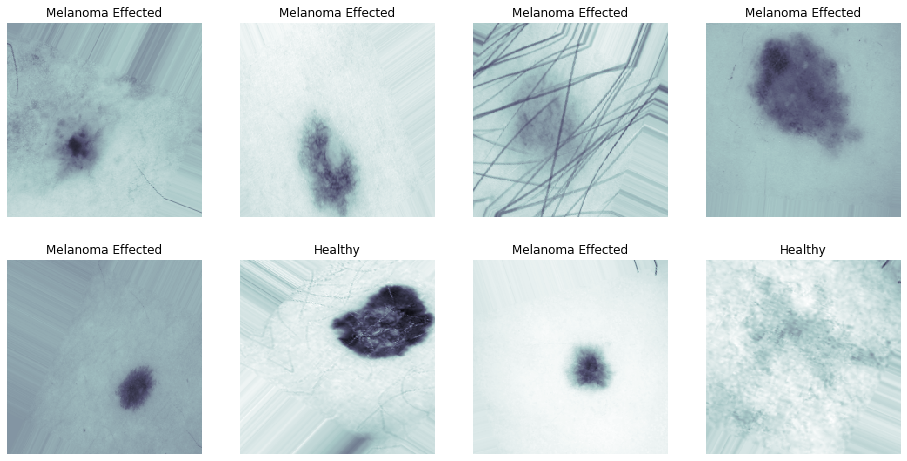

In [7]:
import matplotlib.pyplot as plt

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = 0, vmax = 1)
    c_ax.set_title('%s' % ('Melanoma Effected' if np.argmax(c_y)>0.5 else 'Healthy'))
    c_ax.axis('off')

In [8]:
from keras.applications import ResNet50
from keras import regularizers
from keras.models import *
from keras.layers import *


img_shape = (IMG_SIZE, IMG_SIZE, 3)
inputs = Input(img_shape)
num_classes = 2

resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape)
outputs = resnet50.output
outputs = BatchNormalization()(outputs)
outputs = GlobalAveragePooling2D()(outputs)
outputs= Dropout(0.5)(outputs)
outputs= Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(outputs)
outputs= Dropout(0.5)(outputs)
outputs = Dense(num_classes, activation = 'softmax')(outputs)
model = Model(inputs = resnet50.input, outputs = outputs)

# transfer learning
for layer in resnet50.layers:
  layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
from keras.callbacks import ModelCheckpoint

saveDir = './saved models/ResNet50 model'

checkpoint = ModelCheckpoint('./saved models/ResNet50 model/CAM Melanoma-ResNet50-bestmodel-{epoch:02d}-{val_acc:.4f}.h5', monitor='val_acc', verbose=1,
                             save_best_only=True, mode='auto')

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

model.fit_generator(train_gen, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_gen, validation_steps=STEP_SIZE_VALID,
                    epochs = 3, callbacks = [checkpoint])



Epoch 1/3
112/333 [=========>....................] - ETA: 48:53 - loss: 0.4304 - acc: 0.8708